### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('dark_background')

### Load Dataset

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv')

In [4]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Exploratory Data Analysis

In [5]:
print(f'Total Data : {df.shape[0]}')
print(f'Total Attribute : {df.shape[1]}')

Total Data : 517
Total Attribute : 13


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [7]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [8]:
df.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [9]:
df.nunique()

X          9
Y          7
month     12
day        7
FFMC     106
DMC      215
DC       219
ISI      119
temp     192
RH        75
wind      21
rain       7
area     251
dtype: int64

In [10]:
df.X.value_counts()

4    91
6    86
2    73
8    61
7    60
3    55
1    48
5    30
9    13
Name: X, dtype: int64

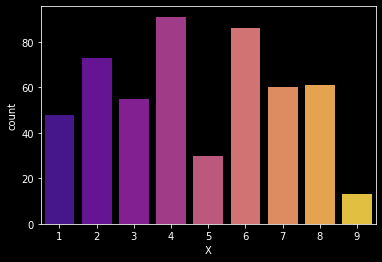

In [11]:
sns.countplot(data=df, x='X', palette='plasma')
plt.show()

In [12]:
df.Y.value_counts()

4    203
5    125
6     74
3     64
2     44
9      6
8      1
Name: Y, dtype: int64

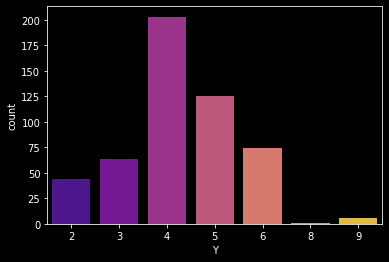

In [13]:
sns.countplot(data=df, x='Y', palette='plasma')
plt.show()

In [14]:
df.day.value_counts()

sun    95
fri    85
sat    84
mon    74
tue    64
thu    61
wed    54
Name: day, dtype: int64

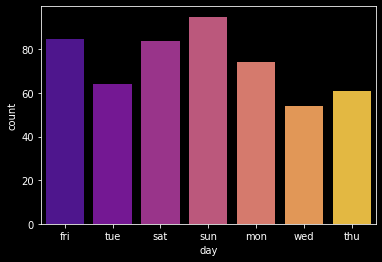

In [15]:
sns.countplot(data=df, x='day', palette='plasma')
plt.show()

In [16]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

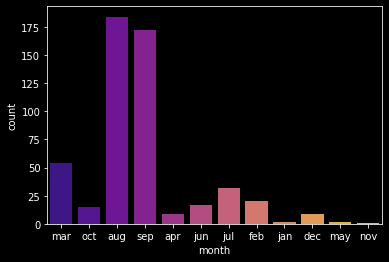

In [17]:
sns.countplot(data=df, x='month', palette='plasma')
plt.show()

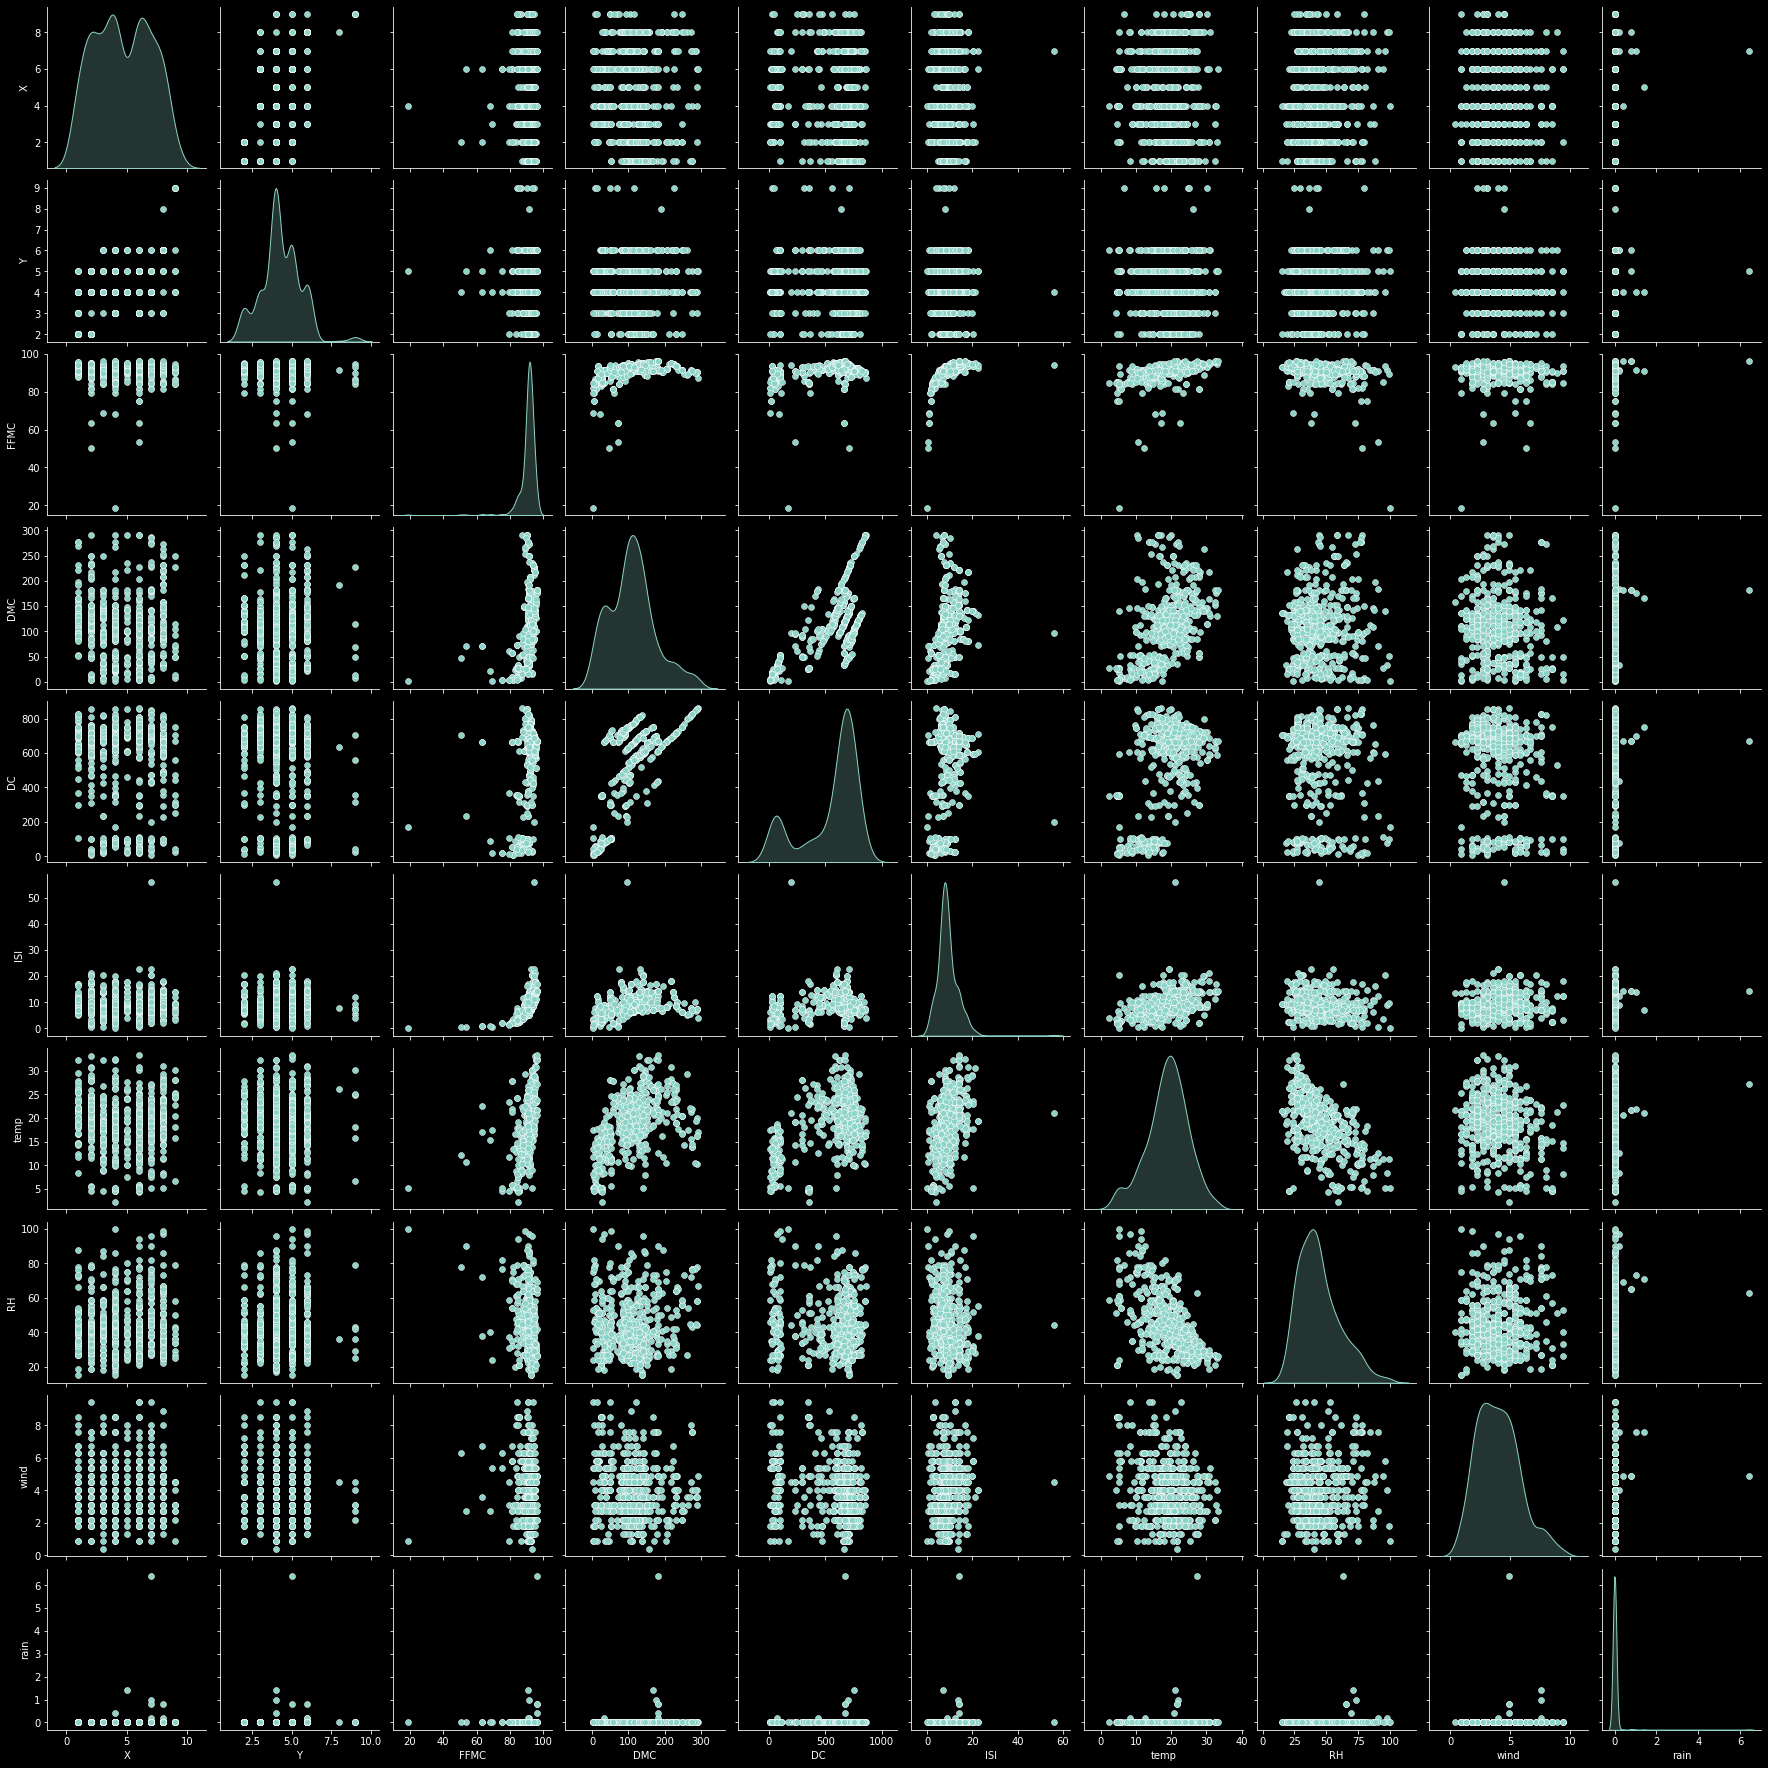

In [18]:
sns.pairplot(df.drop('area', axis=1), diag_kind='kde')
plt.show()

## Data Preparation

### Encode Day and Month

In [19]:
df = pd.get_dummies(df, columns=['day'], prefix='', prefix_sep='')
df = pd.get_dummies(df, columns=['month'], prefix='', prefix_sep='')

### Splitting the data

In [20]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [21]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('area')
test_labels = test_features.pop('area')

### Create Normalizer

In [22]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features)) # Fit Normalizer

### Build the model

In [46]:
# Plot Function
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(visible=None)

# First Experiment

- Playing with the number of hidden layers

- First Try

In [24]:
def first_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(12, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())

    return model

In [25]:
first_try = first_model(normalizer)

In [28]:
%%time
history = first_try.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 6.01 s, sys: 711 ms, total: 6.73 s
Wall time: 10.3 s


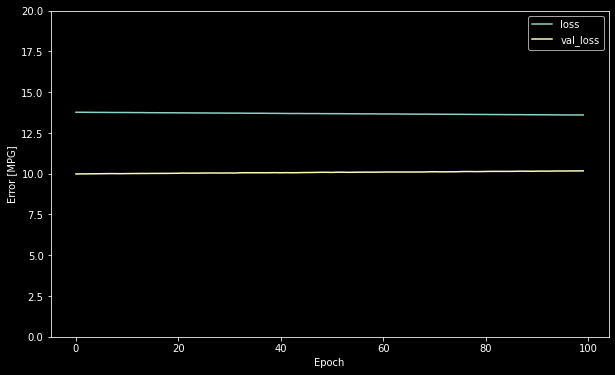

In [37]:
plot_loss(history)

- Second Try

In [38]:
def second_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(32, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(128, activation='relu', kernel_initializer='normal'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())

    return model

In [39]:
second_try = second_model(normalizer)
second_try.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 29)               59        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                960       
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                      

In [42]:
%%time
history = second_try.fit(
    train_features,
    train_labels,
    epochs=1000,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 1min 7s, sys: 6.9 s, total: 1min 14s
Wall time: 1min 9s


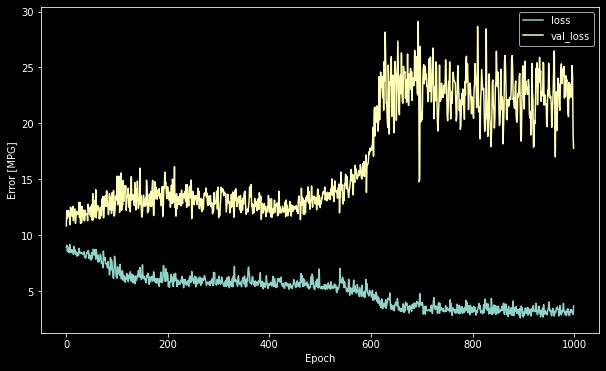

In [47]:
plot_loss(history)

- Third Try

In [48]:
def third_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())

    return model

In [49]:
third_try = third_model(normalizer)
third_try.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 29)               59        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 16)                480       
                                                                 
 dense_9 (Dense)             (None, 32)                544       
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 64)                2112      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                      

In [50]:
%%time
history = third_try.fit(
    train_features,
    train_labels,
    epochs=1000,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 1min 9s, sys: 7.2 s, total: 1min 16s
Wall time: 1min 8s


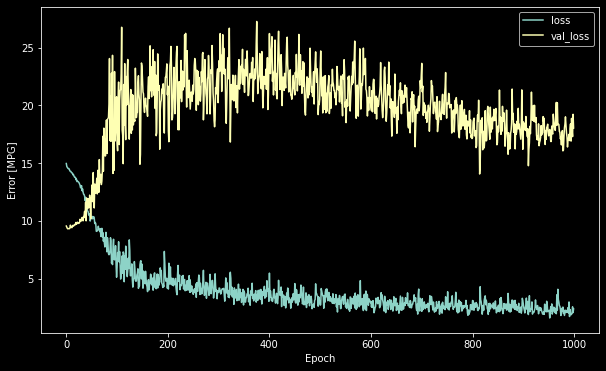

In [51]:
plot_loss(history)

> Conclusion:
1. The more neurons or hidden layer models, the more errors or losses experience a decrease
2. I will choose the third model

# Second Experiment

- Playing with the number of epoch

In [52]:
# fit a model and plot learning curve

def fit_second_model(x_train, y_train, epoch, normalizer=normalizer):

    # define model
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam())

    # fit model
    history = model.fit(
        x_train,
        y_train,
        epochs=epoch,
        verbose=0,
        validation_split = 0.2)
    
    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('epoch='+str(epoch))
    plt.ylim([0, 20])
    plt.legend()

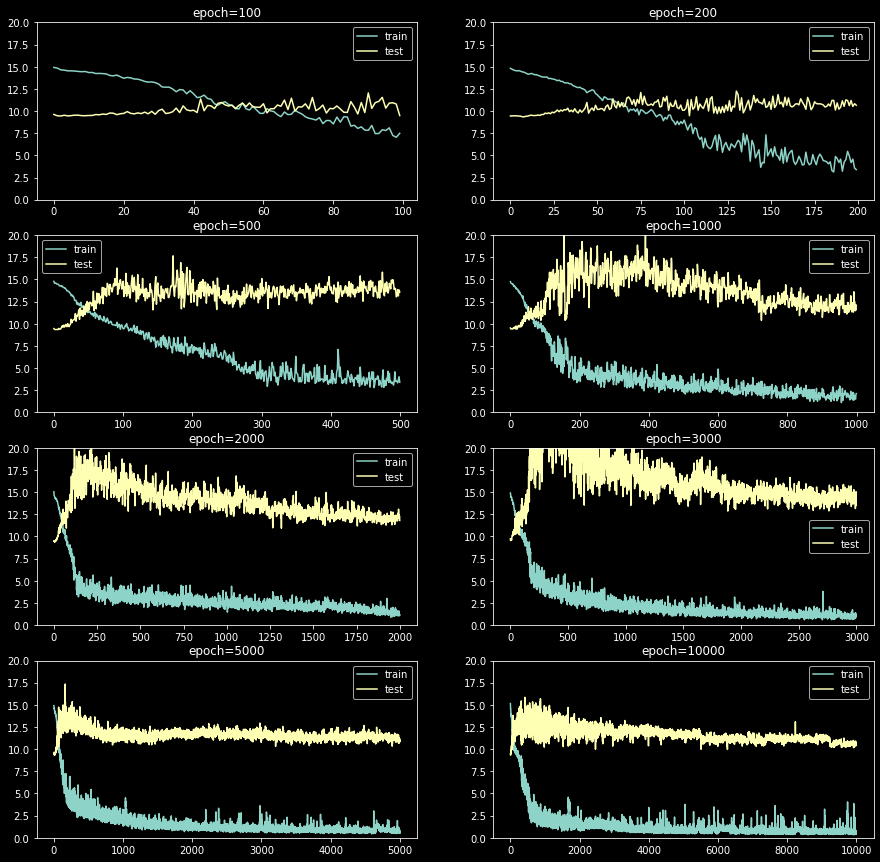

In [53]:
# create learning curves for different Epoch

epoch = [100, 200, 500, 1000, 2000, 3000, 5000, 10000]


plt.figure(figsize=(15, 15))
for i in range(len(epoch)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a learning rate
    fit_second_model(train_features, train_labels, epoch[i])

# show learning curves
plt.show()

> Conclusion:
1. Many epochs will not always make the model experience a decrease in error or loss
2. I will use the epoch of 500 for computing problems and it doesn't look too far from the epoch above it

# Third  Experiment

- Playing with the number of batch size

In [55]:
# fit a model and plot learning curve

def fit_third_model(x_train, y_train, bs, normalizer=normalizer):

    # define model
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam())

    # fit model
    epoch = 500
    history = model.fit(
        x_train,
        y_train,
        epochs=epoch,
        verbose=0,
        batch_size=bs,
        validation_split = 0.2)
    
    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('batchs_size='+str(bs))
    plt.ylim([0, 20])
    plt.legend()

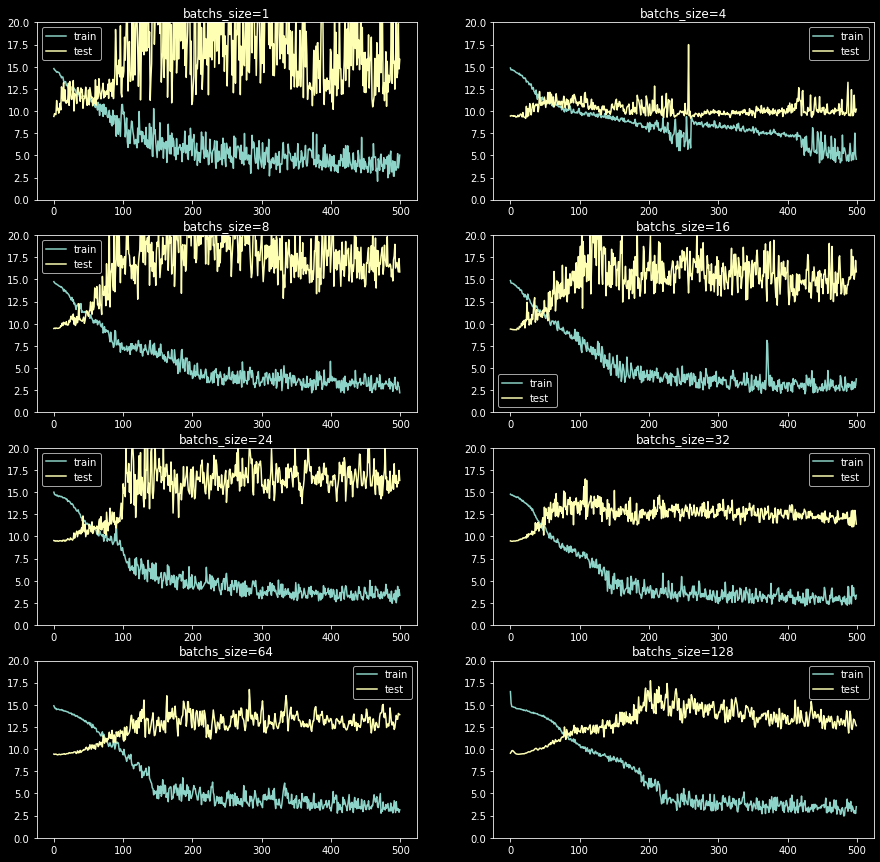

In [56]:
# create learning curves for different Batch Size

bs = [1, 4, 8, 16, 24, 32, 64, 128]


plt.figure(figsize=(15, 15))
for i in range(len(bs)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a learning rate
    fit_third_model(train_features, train_labels, bs[i])

# show learning curves
plt.show()

> Conclusion:
1. More batches make the gap between loss train and loss test very far
2. I will choose the smallest gap which is 4 batch size

# Fourth  Experiment

- Playing with the number of learning rate

In [57]:
# fit a model and plot learning curve

def fit_fourth_model(x_train, y_train, lr, normalizer=normalizer):

    # define model
    model = tf.keras.Sequential([
        normalizer,
        layers.Dense(16, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

    # fit model
    epoch = 500
    bs = 4
    history = model.fit(
        x_train,
        y_train,
        epochs=epoch,
        verbose=0,
        batch_size=bs,
        validation_split = 0.2)
    
    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.title('learning_rate='+str(lr))
    plt.ylim([0, 20])
    plt.legend()

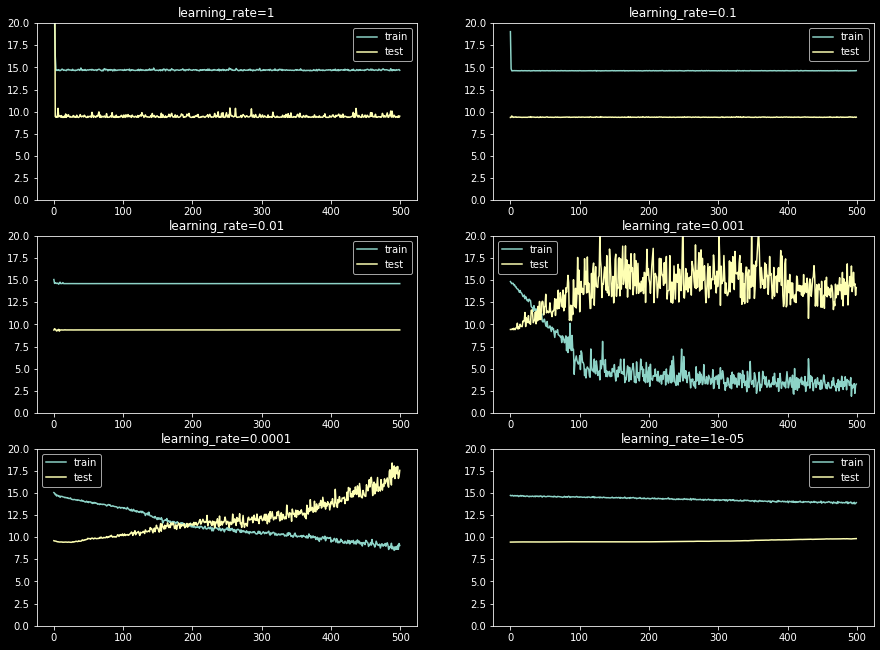

In [58]:
# create learning curves for different Batch Size

lr = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]


plt.figure(figsize=(15, 15))
for i in range(len(lr)):
    
    # determine the plot number
    plot_no = 420 + (i+1)
    plt.subplot(plot_no)
    
    # fit model and plot learning curves for a learning rate
    fit_fourth_model(train_features, train_labels, lr[i])

# show learning curves
plt.show()

> Conclusion:
1. Some number of learning rates do not show significant changes
2. I will choose the learning rate of 0.001

# Final Model

In [54]:
def best_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(32, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(128, activation='relu', kernel_initializer='normal'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer='normal'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

In [59]:
best_build = best_model(normalizer)
best_build.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 29)               59        
 n)                                                              
                                                                 
 dense_192 (Dense)           (None, 32)                960       
                                                                 
 dense_193 (Dense)           (None, 64)                2112      
                                                                 
 dense_194 (Dense)           (None, 64)                4160      
                                                                 
 dense_195 (Dense)           (None, 64)                4160      
                                                                 
 dense_196 (Dense)           (None, 128)               8320      
                                                     

In [60]:
%%time
history = best_build.fit(
    train_features,
    train_labels,
    epochs=500,
    verbose=0,
    batch_size=4,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3min 4s, sys: 18 s, total: 3min 22s
Wall time: 2min 39s


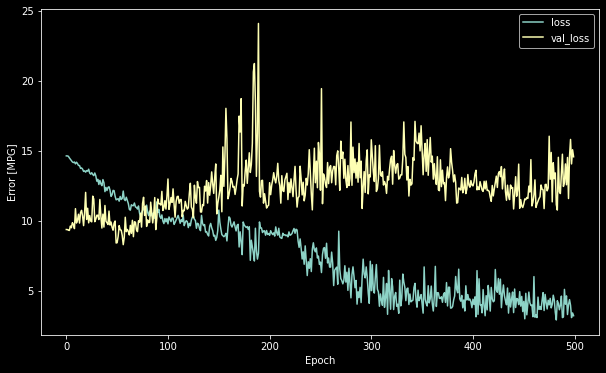

In [61]:
plot_loss(history)

# Final Model using EarlyStopping

In [62]:
def final_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(32, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(64, activation='relu', kernel_initializer='normal'),
        layers.Dense(128, activation='relu', kernel_initializer='normal'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', kernel_initializer='normal'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

    return model

In [63]:
final_build_model = final_model(normalizer)
final_build_model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 29)               59        
 n)                                                              
                                                                 
 dense_199 (Dense)           (None, 32)                960       
                                                                 
 dense_200 (Dense)           (None, 64)                2112      
                                                                 
 dense_201 (Dense)           (None, 64)                4160      
                                                                 
 dense_202 (Dense)           (None, 64)                4160      
                                                                 
 dense_203 (Dense)           (None, 128)               8320      
                                                     

In [64]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [65]:
%%time
history = final_build_model.fit(
    train_features,
    train_labels,
    epochs=500,
    verbose=0,
    batch_size=4,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    callbacks=[es])

Epoch 208: early stopping
CPU times: user 1min 17s, sys: 7.22 s, total: 1min 25s
Wall time: 1min 6s


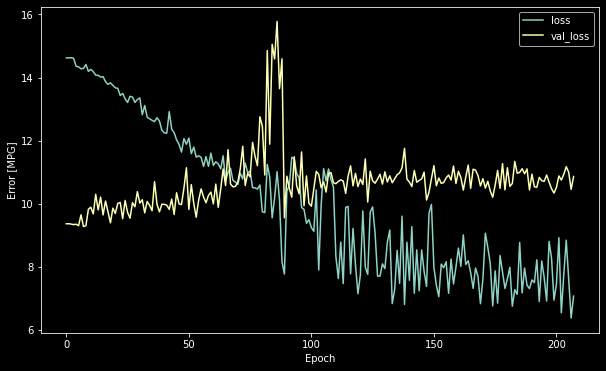

In [66]:
plot_loss(history)

### Prediction

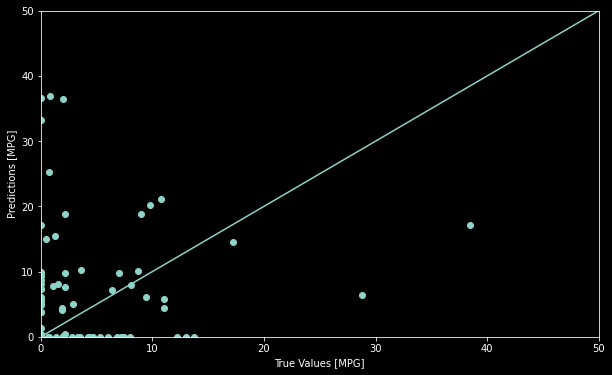

In [72]:
test_predictions = final_build_model.predict(test_features).flatten()

plt.figure(figsize=(10,6))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [73]:
final_build_model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets
